In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings

warnings.filterwarnings("ignore")

# === –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ñ–∞–π–ª–∞ ALRS ===
alrs_raw = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_candles.csv")
alrs = alrs_raw[["begin", "close"]].copy()
alrs["Date"] = pd.to_datetime(alrs["begin"]).dt.date
alrs = alrs.rename(columns={"close": "Stock Close"}).drop(columns=["begin"])
alrs = alrs.groupby("Date").first().reset_index()
alrs["Date"] = pd.to_datetime(alrs["Date"])
alrs.set_index("Date", inplace=True)

# === –§—É–Ω–∫—Ü–∏–∏ ===
def load_and_prepare(file_path, date_col, value_col, skip_rows=0, date_format=None):
    df = pd.read_csv(file_path, skiprows=skip_rows)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_non_standard_file(file_path, date_col, value_col):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = [date_col, value_col, 'High', 'Low', 'Open', 'Volume']
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_vix_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[['Close']].rename(columns={'Close': 'VIX'})

# === –ü—É—Ç–∏ –∫ –¥–∞–Ω–Ω—ã–º ===
file_paths = {
    "imoex": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/imoex_candles.csv",
    "rtsi": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/rtsi_candles.csv",
    "vix": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/vix_data.csv",
    "gvz": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/gvz_data.csv",
    "gold": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/gold_data.csv",
    "oil": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/oil_data.csv",
    "moexog": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/moexog_candles.csv",
    "rgbi": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/rgbi_candles.csv",
    "macro": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/macroeconomic_data.csv"
}

# === –ó–∞–≥—Ä—É–∑–∫–∞ —ç–∫–∑–æ–≥–µ–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö ===
imoex = load_and_prepare(file_paths["imoex"], "begin", "close").rename(columns={"close": "IMOEX Close"})
rtsi = load_and_prepare(file_paths["rtsi"], "begin", "close").rename(columns={"close": "RTSI Close"})
moexog = load_and_prepare(file_paths["moexog"], "begin", "close").rename(columns={"close": "MOEXOG Close"})
rgbi = load_and_prepare(file_paths["rgbi"], "begin", "close").rename(columns={"close": "RGBI Close"})
vix = process_vix_file(file_paths["vix"])
gvz = process_non_standard_file(file_paths["gvz"], "Date", "Close").rename(columns={"Close": "GVZ"})
gold = process_non_standard_file(file_paths["gold"], "Date", "Close").rename(columns={"Close": "Gold Price"})
oil = process_non_standard_file(file_paths["oil"], "Date", "Close").rename(columns={"Close": "Oil Price"})

# === –ú–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏–∫–∞ ===
macro_df = pd.read_csv(file_paths["macro"])
macro_df['date'] = pd.to_datetime(macro_df['date'], errors='coerce')
macro_df = macro_df.dropna(subset=['date'])
macro_df.set_index('date', inplace=True)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df = macro_df[['inflation', 'key_rate', 'usd_rate', 'cny_rate']]
macro_df.columns = ['Inflation', 'Key Rate', 'USD Rate', 'CNY Rate']
macro_df = macro_df.resample('D').interpolate()

# === –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö ===
merged_data = pd.concat(
    [alrs, imoex, rtsi, moexog, rgbi, vix, gvz, gold, oil, macro_df],
    axis=1
)

# === –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ ===
merged_data = merged_data.interpolate(method='linear')
merged_data = merged_data[::-1].ffill()[::-1]

# === –°–±—Ä–æ—Å –∏–Ω–¥–µ–∫—Å–∞ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Å –∫–æ–ª–æ–Ω–∫–æ–π "Date" ===
merged_data = merged_data.reset_index().rename(columns={"index": "Date"})
output_path = "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_merged_data.csv"
merged_data.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {output_path}")

# –ü—Ä–æ—Å–º–æ—Ç—Ä –ø–µ—Ä–≤—ã—Ö —Å—Ç—Ä–æ–∫
display(merged_data.head())


‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_merged_data.csv


Date  Stock Close  IMOEX Close  RTSI Close  MOEXOG Close  RGBI Close  \
0 2015-01-01        98.73      1435.66       761.3       3640.27      104.98   
1 2015-01-02        98.73      1435.66       761.3       3640.27      104.98   
2 2015-01-03        98.73      1435.66       761.3       3640.27      104.98   
3 2015-01-04        98.73      1435.66       761.3       3640.27      104.98   
4 2015-01-05        98.73      1435.66       761.3       3640.27      104.98   

         VIX        GVZ   Gold Price  Oil Price  Inflation   Key Rate  \
0  17.790001  20.230000  1186.000000  56.419998  68.368100  56.237600   
1  17.790001  20.230000  1186.000000  56.419998  68.867017  56.779158   
2  18.500001  20.573333  1191.966675  55.316666  69.365933  57.320717   
3  19.210000  20.916667  1197.933350  54.213333  69.864850  57.862275   
4  19.920000  21.260000  1203.900024  53.110001  70.363767  58.403833   

   USD Rate  CNY Rate  
0     60.85    10.916  
1     60.85    10.916  
2     60.85    10.916  
3     60.85    10.916  
4     60.85    10.916

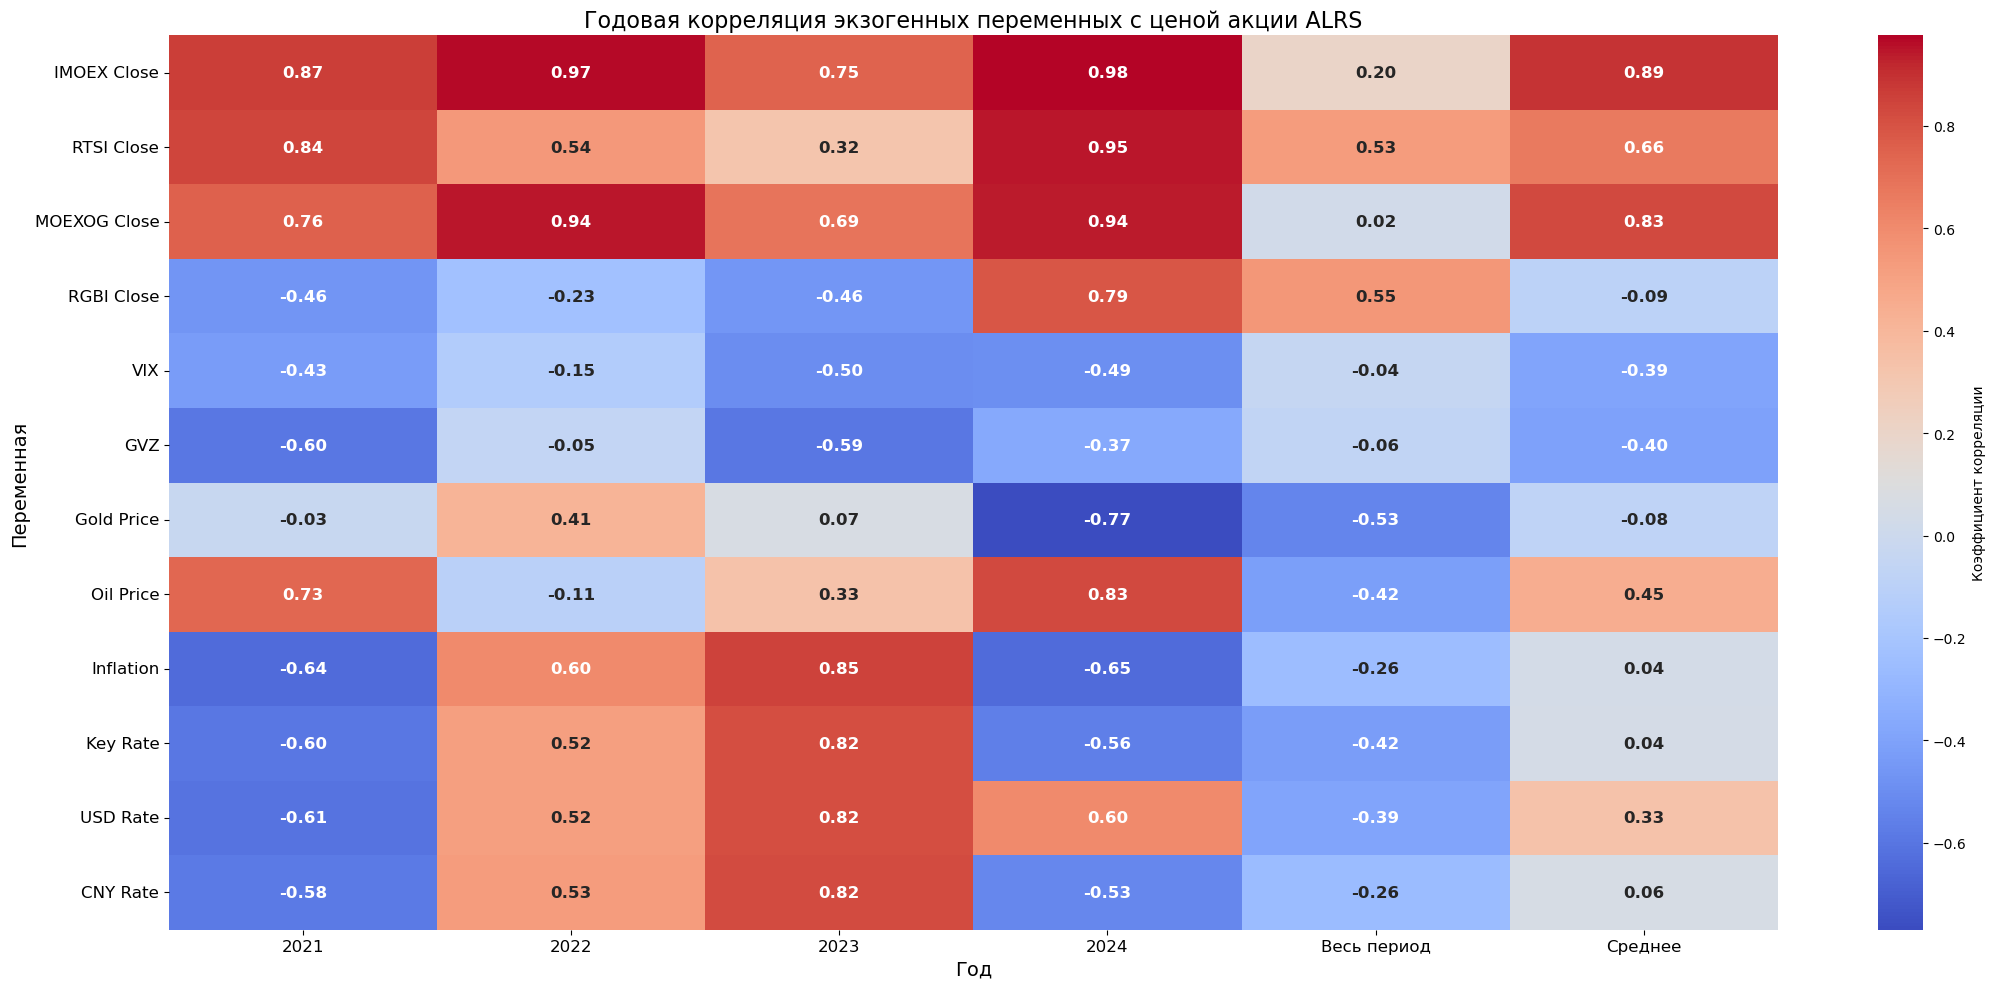

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === –ó–∞–≥—Ä—É–∑–∫–∞ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_merged_data.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace=True)


# --- 2. –ì–æ–¥–æ–≤—ã–µ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ —Å 'Stock Close' –ø–æ –≤—Å–µ–º –≥–æ–¥–∞–º + –í–µ—Å—å –ø–µ—Ä–∏–æ–¥ + –°—Ä–µ–¥–Ω–µ–µ ---
years = range(2021, 2025)
yearly_corrs = {}

for year in years:
    yearly_df = merged_data[merged_data.index.year == year]
    if not yearly_df.empty:
        corr = yearly_df.corr(numeric_only=True)
        yearly_corrs[str(year)] = corr["Stock Close"].drop("Stock Close", errors="ignore")

# –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥
corr_all_period = merged_data.corr(numeric_only=True)["Stock Close"].drop("Stock Close", errors="ignore")
yearly_corrs["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"] = corr_all_period

# –°–≤–æ–¥–Ω–∞—è —Ç–∞–±–ª–∏—Ü–∞
corr_by_year_df = pd.DataFrame(yearly_corrs)
years_only = [str(year) for year in years if str(year) in corr_by_year_df.columns]
corr_by_year_df["–°—Ä–µ–¥–Ω–µ–µ"] = corr_by_year_df[years_only].mean(axis=1)

# --- –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ---
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_by_year_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': '–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏'},
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("–ì–æ–¥–æ–≤–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è —ç–∫–∑–æ–≥–µ–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö —Å —Ü–µ–Ω–æ–π –∞–∫—Ü–∏–∏ ALRS", fontsize=16)
plt.xlabel("–ì–æ–¥", fontsize=14)
plt.ylabel("–ü–µ—Ä–µ–º–µ–Ω–Ω–∞—è", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# –í–µ—Ä–Ω—É—Ç—å Date –æ–±—Ä–∞—Ç–Ω–æ –≤ –∫–æ–ª–æ–Ω–∫—É
merged_data.reset_index(inplace=True)


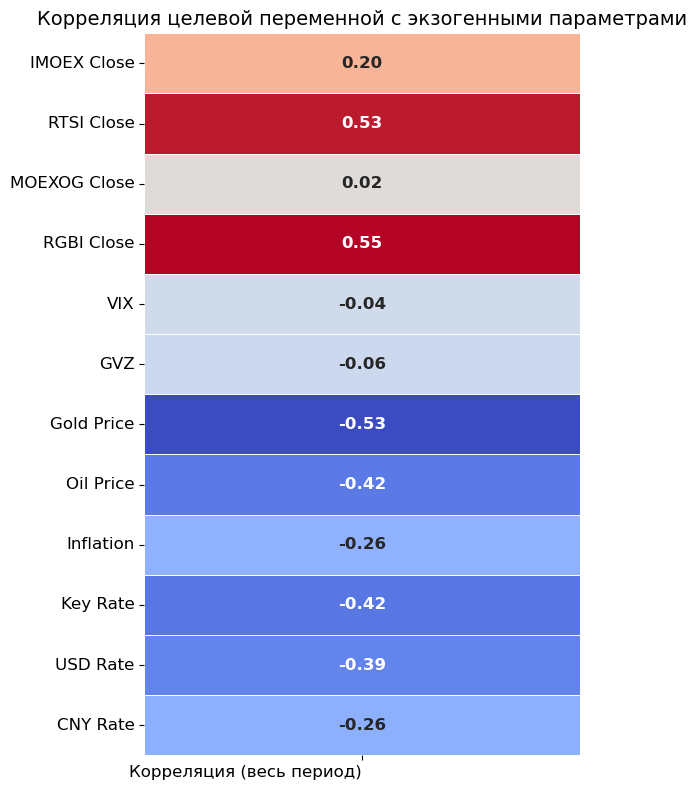

In [3]:
# –£–±–∏—Ä–∞–µ–º –∫–æ–ª–æ–Ω–∫—É Date –∏–∑ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ä–∞—Å—á—ë—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π
data_for_corr = merged_data.drop(columns=["Date"], errors="ignore")

# –ü–µ—Ä–µ—Å—á—ë—Ç –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π —Ç–æ–ª—å–∫–æ –¥–ª—è –≤—Å–µ–≥–æ –ø–µ—Ä–∏–æ–¥–∞
corr_all_period = data_for_corr.corr()["Stock Close"].drop("Stock Close", errors="ignore")

# –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∫ DataFrame –¥–ª—è —Ç–µ–ø–ª–æ–≤–æ–π –∫–∞—Ä—Ç—ã
corr_df = pd.DataFrame(corr_all_period)
corr_df.columns = ["–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)"]

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ —Ç–µ–ø–ª–æ–≤–æ–π –∫–∞—Ä—Ç—ã
plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π —Å —ç–∫–∑–æ–≥–µ–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏", fontsize=14)
plt.xticks(fontsize=12, ha='right')  # –ù–∞–∫–ª–æ–Ω 45¬∞ –∏ –≤—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ –≤–ø—Ä–∞–≤–æ
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


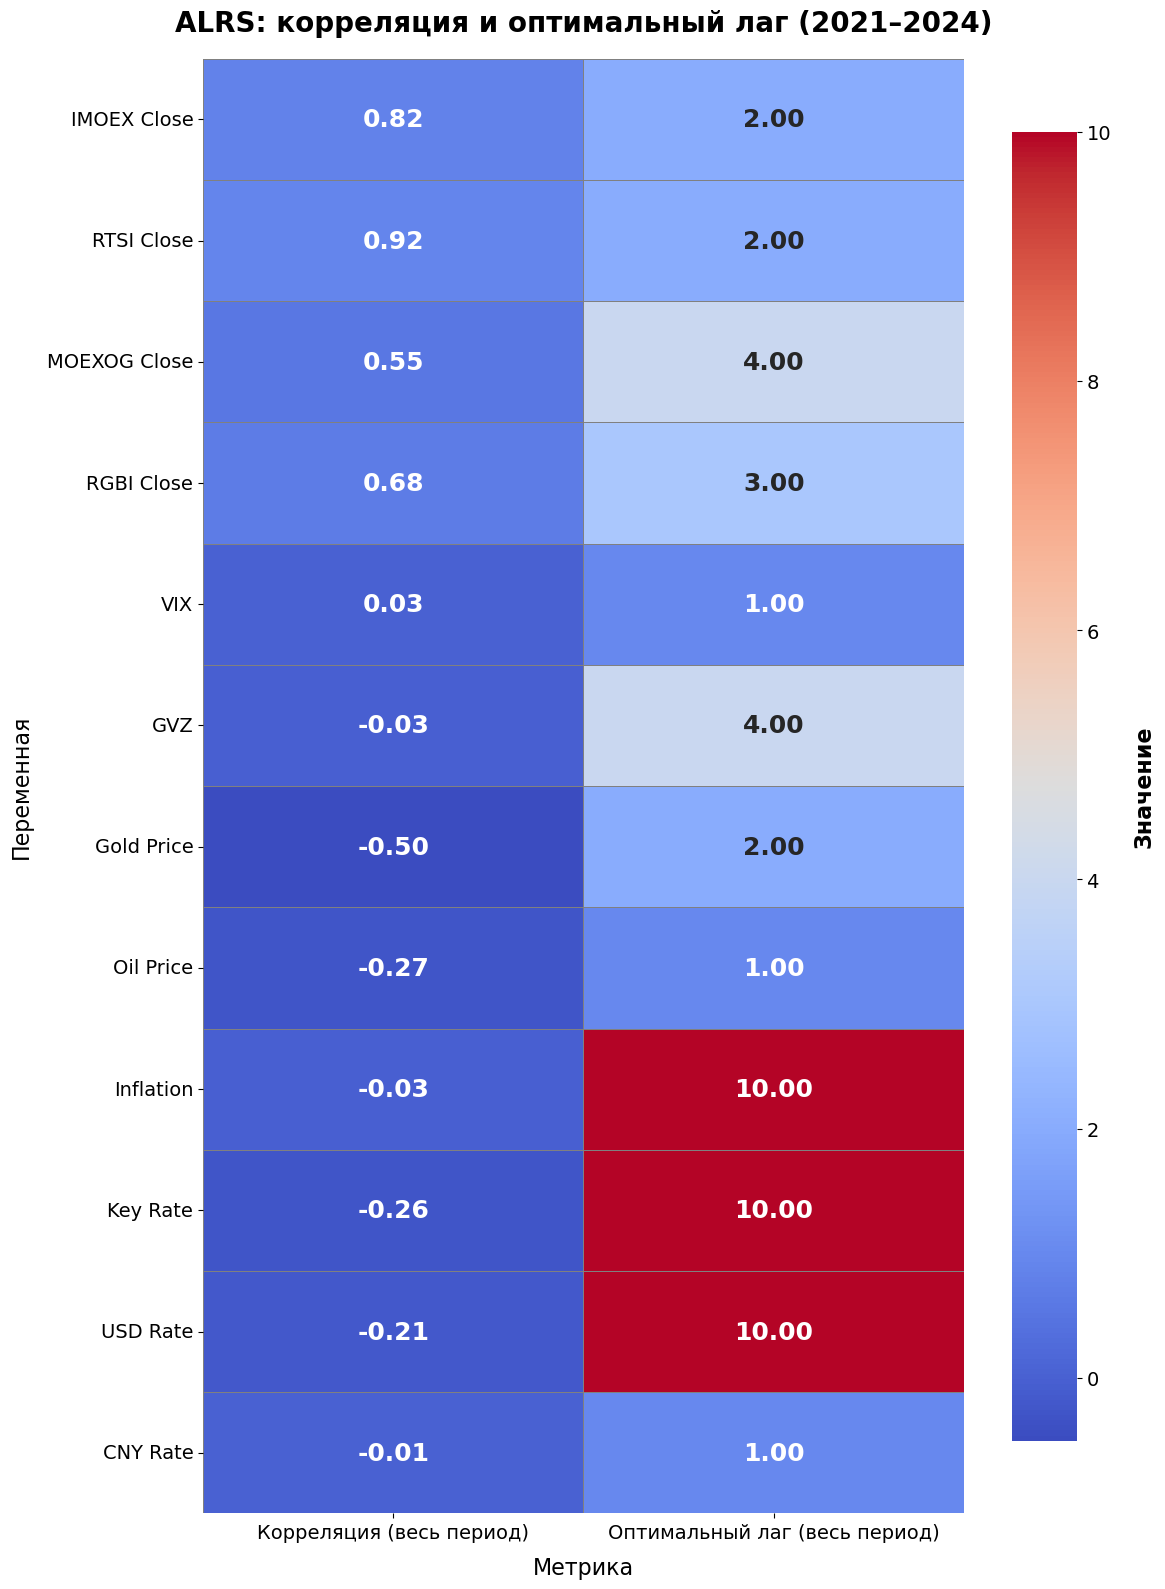

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö ===
df = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # –£–¥–∞–ª—è–µ–º –∫–æ–Ω—Å—Ç–∞–Ω—Ç–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã

# === –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö ===
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

# === –ò–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏—è –∏ –æ—á–∏—Å—Ç–∫–∞ ===
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === –ì–æ–¥–æ–≤—ã–µ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

# === –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥ ===
corr_total = df.corr()
corr_by_year["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"] = corr_total[target].drop(target)

# === –¢–∞–±–ª–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –ø–æ –≥–æ–¥–∞–º ===
corr_by_year_df = pd.DataFrame(corr_by_year)

# === –†–∞—Å—á—ë—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ª–∞–≥–æ–≤ (–ì—Ä–µ–π–Ω–¥–∂–µ—Ä) ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

lags_total_series = pd.Series(lags_total, name="–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)")
corr_total_series = corr_by_year_df["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"]

# === –ò—Ç–æ–≥–æ–≤–∞—è —Ç–∞–±–ª–∏—Ü–∞ ARIMAX-–∞–Ω–∞–ª–∏–∑–∞ ===
arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)", "–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)"]

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ç–µ–ø–ª–æ–≤–æ–π –∫–∞—Ä—Ç—ã ===
plt.figure(figsize=(12, 16))

heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={"label": "–ó–Ω–∞—á–µ–Ω–∏–µ", "shrink": 0.9}
)

plt.title("ALRS: –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (2021‚Äì2024)", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("–ú–µ—Ç—Ä–∏–∫–∞", fontsize=16, labelpad=10)
plt.ylabel("–ü–µ—Ä–µ–º–µ–Ω–Ω–∞—è", fontsize=16, labelpad=10)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.subplots_adjust(left=0.3)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("–ó–Ω–∞—á–µ–Ω–∏–µ", fontsize=16, weight="bold", labelpad=15)

plt.tight_layout()
plt.show()


üîÑ Rolling forecast –Ω–∞—á–∞—Ç...


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   0%|                                                                        | 0/364 [00:00<?, ?—à–∞–≥/s]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 0-1 | –î–∞—Ç–∞: 2024-01-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   0%|‚ñè                                                               | 1/364 [00:04<26:40,  4.41s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 1-2 | –î–∞—Ç–∞: 2024-01-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñé                                                               | 2/364 [00:09<29:05,  4.82s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 2-3 | –î–∞—Ç–∞: 2024-01-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñå                                                               | 3/364 [00:13<26:46,  4.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 3-4 | –î–∞—Ç–∞: 2024-01-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñã                                                               | 4/364 [00:17<26:39,  4.44s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 4-5 | –î–∞—Ç–∞: 2024-01-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñâ                                                               | 5/364 [00:22<25:45,  4.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 5-6 | –î–∞—Ç–∞: 2024-01-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà                                                               | 6/364 [00:26<25:11,  4.22s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 6-7 | –î–∞—Ç–∞: 2024-01-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà‚ñè                                                              | 7/364 [00:31<26:39,  4.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 7-8 | –î–∞—Ç–∞: 2024-01-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà‚ñç                                                              | 8/364 [00:35<25:30,  4.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 8-9 | –î–∞—Ç–∞: 2024-01-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà‚ñå                                                              | 9/364 [00:38<24:48,  4.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 9-10 | –î–∞—Ç–∞: 2024-01-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   3%|‚ñà‚ñã                                                             | 10/364 [00:44<26:21,  4.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 10-11 | –î–∞—Ç–∞: 2024-01-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   3%|‚ñà‚ñâ                                                             | 11/364 [00:48<26:35,  4.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 11-12 | –î–∞—Ç–∞: 2024-01-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   3%|‚ñà‚ñà                                                             | 12/364 [00:52<26:06,  4.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 12-13 | –î–∞—Ç–∞: 2024-01-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñé                                                            | 13/364 [00:56<24:51,  4.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 13-14 | –î–∞—Ç–∞: 2024-01-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñç                                                            | 14/364 [01:00<24:11,  4.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 14-15 | –î–∞—Ç–∞: 2024-01-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñå                                                            | 15/364 [01:05<25:21,  4.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 15-16 | –î–∞—Ç–∞: 2024-01-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñä                                                            | 16/364 [01:09<25:28,  4.39s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 16-17 | –î–∞—Ç–∞: 2024-01-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñâ                                                            | 17/364 [01:14<26:03,  4.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 17-18 | –î–∞—Ç–∞: 2024-01-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñà                                                            | 18/364 [01:18<25:01,  4.34s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 18-19 | –î–∞—Ç–∞: 2024-01-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñà‚ñé                                                           | 19/364 [01:23<25:19,  4.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 19-20 | –î–∞—Ç–∞: 2024-01-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñà‚ñç                                                           | 20/364 [01:27<25:07,  4.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 20-21 | –î–∞—Ç–∞: 2024-01-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   6%|‚ñà‚ñà‚ñà‚ñã                                                           | 21/364 [01:31<24:58,  4.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 21-22 | –î–∞—Ç–∞: 2024-01-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   6%|‚ñà‚ñà‚ñà‚ñä                                                           | 22/364 [01:36<24:42,  4.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 22-23 | –î–∞—Ç–∞: 2024-01-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   6%|‚ñà‚ñà‚ñà‚ñâ                                                           | 23/364 [01:40<23:48,  4.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 23-24 | –î–∞—Ç–∞: 2024-01-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                          | 24/364 [01:44<24:07,  4.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 24-25 | –î–∞—Ç–∞: 2024-01-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                          | 25/364 [01:48<23:47,  4.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 25-26 | –î–∞—Ç–∞: 2024-01-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                          | 26/364 [01:52<23:40,  4.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 26-27 | –î–∞—Ç–∞: 2024-01-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñã                                                          | 27/364 [01:56<23:36,  4.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 27-28 | –î–∞—Ç–∞: 2024-01-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                          | 28/364 [02:01<24:12,  4.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 28-29 | –î–∞—Ç–∞: 2024-01-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñà                                                          | 29/364 [02:06<24:44,  4.43s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 29-30 | –î–∞—Ç–∞: 2024-01-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                         | 30/364 [02:09<23:04,  4.14s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 30-31 | –î–∞—Ç–∞: 2024-02-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 31/364 [02:13<22:56,  4.13s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 31-32 | –î–∞—Ç–∞: 2024-02-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                         | 32/364 [02:18<24:13,  4.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 32-33 | –î–∞—Ç–∞: 2024-02-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                         | 33/364 [02:24<25:43,  4.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 33-34 | –î–∞—Ç–∞: 2024-02-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 34/364 [02:28<24:50,  4.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 34-35 | –î–∞—Ç–∞: 2024-02-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                         | 35/364 [02:32<24:26,  4.46s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 35-36 | –î–∞—Ç–∞: 2024-02-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                        | 36/364 [02:37<24:57,  4.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 36-37 | –î–∞—Ç–∞: 2024-02-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                        | 37/364 [02:42<25:55,  4.76s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 37-38 | –î–∞—Ç–∞: 2024-02-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 38/364 [02:47<25:19,  4.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 38-39 | –î–∞—Ç–∞: 2024-02-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                        | 39/364 [02:51<24:43,  4.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 39-40 | –î–∞—Ç–∞: 2024-02-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                        | 40/364 [02:56<25:29,  4.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 40-41 | –î–∞—Ç–∞: 2024-02-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                        | 41/364 [03:01<25:11,  4.68s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 41-42 | –î–∞—Ç–∞: 2024-02-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                       | 42/364 [03:05<24:06,  4.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 42-43 | –î–∞—Ç–∞: 2024-02-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                       | 43/364 [03:11<26:32,  4.96s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 43-44 | –î–∞—Ç–∞: 2024-02-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                       | 44/364 [03:16<27:46,  5.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 44-45 | –î–∞—Ç–∞: 2024-02-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                       | 45/364 [03:22<27:29,  5.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 45-46 | –î–∞—Ç–∞: 2024-02-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 46/364 [03:27<28:11,  5.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 46-47 | –î–∞—Ç–∞: 2024-02-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                      | 47/364 [03:32<26:42,  5.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 47-48 | –î–∞—Ç–∞: 2024-02-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                      | 48/364 [03:37<27:24,  5.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 48-49 | –î–∞—Ç–∞: 2024-02-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                      | 49/364 [03:42<26:21,  5.02s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 49-50 | –î–∞—Ç–∞: 2024-02-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 50/364 [03:47<27:00,  5.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 50-51 | –î–∞—Ç–∞: 2024-02-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                      | 51/364 [04:00<38:55,  7.46s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 51-52 | –î–∞—Ç–∞: 2024-02-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                      | 52/364 [04:15<50:43,  9.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 52-53 | –î–∞—Ç–∞: 2024-02-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                     | 53/364 [04:30<59:06, 11.41s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 53-54 | –î–∞—Ç–∞: 2024-02-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 54/364 [04:43<1:01:15, 11.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 54-55 | –î–∞—Ç–∞: 2024-02-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 55/364 [04:56<1:01:48, 12.00s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 55-56 | –î–∞—Ç–∞: 2024-02-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 56/364 [05:08<1:02:20, 12.14s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 56-57 | –î–∞—Ç–∞: 2024-02-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                   | 57/364 [05:20<1:02:14, 12.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 57-58 | –î–∞—Ç–∞: 2024-02-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                     | 58/364 [05:24<49:11,  9.64s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 58-59 | –î–∞—Ç–∞: 2024-02-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                    | 59/364 [05:28<40:19,  7.93s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 59-60 | –î–∞—Ç–∞: 2024-03-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 60/364 [05:40<46:03,  9.09s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 60-61 | –î–∞—Ç–∞: 2024-03-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 61/364 [05:44<38:30,  7.63s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 61-62 | –î–∞—Ç–∞: 2024-03-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                    | 62/364 [05:48<32:38,  6.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 62-63 | –î–∞—Ç–∞: 2024-03-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                    | 63/364 [05:52<29:12,  5.82s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 63-64 | –î–∞—Ç–∞: 2024-03-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 64/364 [05:56<25:58,  5.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 64-65 | –î–∞—Ç–∞: 2024-03-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                   | 65/364 [06:00<23:46,  4.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 65-66 | –î–∞—Ç–∞: 2024-03-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 66/364 [06:04<23:38,  4.76s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 66-67 | –î–∞—Ç–∞: 2024-03-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                   | 67/364 [06:08<22:02,  4.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 67-68 | –î–∞—Ç–∞: 2024-03-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 68/364 [06:13<22:14,  4.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 68-69 | –î–∞—Ç–∞: 2024-03-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                   | 69/364 [06:16<20:56,  4.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 69-70 | –î–∞—Ç–∞: 2024-03-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                   | 70/364 [06:21<20:50,  4.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 70-71 | –î–∞—Ç–∞: 2024-03-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 71/364 [06:25<20:28,  4.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 71-72 | –î–∞—Ç–∞: 2024-03-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                  | 72/364 [06:28<19:23,  3.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 72-73 | –î–∞—Ç–∞: 2024-03-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                  | 73/364 [06:33<19:42,  4.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 73-74 | –î–∞—Ç–∞: 2024-03-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 74/364 [06:36<19:06,  3.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 74-75 | –î–∞—Ç–∞: 2024-03-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 75/364 [06:40<18:49,  3.91s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 75-76 | –î–∞—Ç–∞: 2024-03-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                 | 76/364 [06:44<18:54,  3.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 76-77 | –î–∞—Ç–∞: 2024-03-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                 | 77/364 [06:48<19:02,  3.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 77-78 | –î–∞—Ç–∞: 2024-03-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 78/364 [06:52<18:40,  3.92s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 78-79 | –î–∞—Ç–∞: 2024-03-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                 | 79/364 [07:05<32:21,  6.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 79-80 | –î–∞—Ç–∞: 2024-03-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                 | 80/364 [07:21<44:00,  9.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 80-81 | –î–∞—Ç–∞: 2024-03-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                 | 81/364 [07:34<49:24, 10.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 81-82 | –î–∞—Ç–∞: 2024-03-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 82/364 [07:48<54:22, 11.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 82-83 | –î–∞—Ç–∞: 2024-03-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                | 83/364 [08:00<54:13, 11.58s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 83-84 | –î–∞—Ç–∞: 2024-03-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 84/364 [08:12<55:30, 11.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 84-85 | –î–∞—Ç–∞: 2024-03-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                | 85/364 [08:27<59:47, 12.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 85-86 | –î–∞—Ç–∞: 2024-03-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 86/364 [08:41<1:00:20, 13.02s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 86-87 | –î–∞—Ç–∞: 2024-03-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 87/364 [08:53<58:42, 12.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 87-88 | –î–∞—Ç–∞: 2024-03-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 88/364 [09:05<57:32, 12.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 88-89 | –î–∞—Ç–∞: 2024-03-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 89/364 [09:16<55:58, 12.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 89-90 | –î–∞—Ç–∞: 2024-03-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                               | 90/364 [09:30<58:28, 12.80s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 90-91 | –î–∞—Ç–∞: 2024-04-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 91/364 [09:42<57:09, 12.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 91-92 | –î–∞—Ç–∞: 2024-04-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 92/364 [09:54<56:11, 12.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 92-93 | –î–∞—Ç–∞: 2024-04-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                             | 93/364 [10:10<1:00:11, 13.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 93-94 | –î–∞—Ç–∞: 2024-04-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 94/364 [10:25<1:01:51, 13.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 94-95 | –î–∞—Ç–∞: 2024-04-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                             | 95/364 [10:38<1:00:58, 13.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 95-96 | –î–∞—Ç–∞: 2024-04-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 96/364 [10:53<1:03:16, 14.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 96-97 | –î–∞—Ç–∞: 2024-04-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 97/364 [11:08<1:03:06, 14.18s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 97-98 | –î–∞—Ç–∞: 2024-04-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 98/364 [11:23<1:04:10, 14.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 98-99 | –î–∞—Ç–∞: 2024-04-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 99/364 [11:38<1:04:32, 14.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 99-100 | –î–∞—Ç–∞: 2024-04-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 100/364 [11:52<1:03:37, 14.46s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 100-101 | –î–∞—Ç–∞: 2024-04-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 101/364 [12:05<1:02:23, 14.23s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 101-102 | –î–∞—Ç–∞: 2024-04-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                           | 102/364 [12:20<1:02:15, 14.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 102-103 | –î–∞—Ç–∞: 2024-04-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 103/364 [12:33<1:00:55, 14.00s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 103-104 | –î–∞—Ç–∞: 2024-04-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                          | 104/364 [12:47<1:00:31, 13.97s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 104-105 | –î–∞—Ç–∞: 2024-04-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                            | 105/364 [13:01<59:55, 13.88s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 105-106 | –î–∞—Ç–∞: 2024-04-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 106/364 [13:14<59:12, 13.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 106-107 | –î–∞—Ç–∞: 2024-04-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                           | 107/364 [13:28<58:29, 13.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 107-108 | –î–∞—Ç–∞: 2024-04-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 108/364 [13:41<57:52, 13.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 108-109 | –î–∞—Ç–∞: 2024-04-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                           | 109/364 [13:55<57:40, 13.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 109-110 | –î–∞—Ç–∞: 2024-04-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 110/364 [14:08<57:47, 13.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 110-111 | –î–∞—Ç–∞: 2024-04-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 111/364 [14:22<57:35, 13.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 111-112 | –î–∞—Ç–∞: 2024-04-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                           | 112/364 [14:36<58:07, 13.84s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 112-113 | –î–∞—Ç–∞: 2024-04-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 113/364 [14:52<1:00:14, 14.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 113-114 | –î–∞—Ç–∞: 2024-04-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 114/364 [15:07<1:01:00, 14.64s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 114-115 | –î–∞—Ç–∞: 2024-04-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                         | 115/364 [15:23<1:01:55, 14.92s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 115-116 | –î–∞—Ç–∞: 2024-04-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                         | 116/364 [15:38<1:01:26, 14.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 116-117 | –î–∞—Ç–∞: 2024-04-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                        | 117/364 [15:52<1:00:50, 14.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 117-118 | –î–∞—Ç–∞: 2024-04-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                        | 118/364 [16:07<1:00:22, 14.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 118-119 | –î–∞—Ç–∞: 2024-04-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 119/364 [16:23<1:02:00, 15.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 119-120 | –î–∞—Ç–∞: 2024-04-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 120/364 [16:37<1:00:50, 14.96s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 120-121 | –î–∞—Ç–∞: 2024-05-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                        | 121/364 [16:53<1:01:33, 15.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 121-122 | –î–∞—Ç–∞: 2024-05-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                        | 122/364 [17:14<1:07:32, 16.74s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 122-123 | –î–∞—Ç–∞: 2024-05-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 123/364 [17:27<1:02:39, 15.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 123-124 | –î–∞—Ç–∞: 2024-05-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 124/364 [17:44<1:05:15, 16.31s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 124-125 | –î–∞—Ç–∞: 2024-05-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 125/364 [17:57<1:00:47, 15.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 125-126 | –î–∞—Ç–∞: 2024-05-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                        | 126/364 [18:11<58:53, 14.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 126-127 | –î–∞—Ç–∞: 2024-05-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 127/364 [18:24<56:17, 14.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 127-128 | –î–∞—Ç–∞: 2024-05-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 128/364 [18:37<54:52, 13.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 128-129 | –î–∞—Ç–∞: 2024-05-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                        | 129/364 [18:51<53:47, 13.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 129-130 | –î–∞—Ç–∞: 2024-05-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                       | 130/364 [19:04<53:08, 13.63s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 130-131 | –î–∞—Ç–∞: 2024-05-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 131/364 [19:17<52:39, 13.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 131-132 | –î–∞—Ç–∞: 2024-05-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 132/364 [19:31<52:13, 13.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 132-133 | –î–∞—Ç–∞: 2024-05-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 133/364 [19:46<53:50, 13.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 133-134 | –î–∞—Ç–∞: 2024-05-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                       | 134/364 [20:00<53:40, 14.00s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 134-135 | –î–∞—Ç–∞: 2024-05-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 135/364 [20:13<52:57, 13.87s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 135-136 | –î–∞—Ç–∞: 2024-05-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 136/364 [20:28<53:08, 13.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 136-137 | –î–∞—Ç–∞: 2024-05-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 137/364 [20:41<52:44, 13.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 137-138 | –î–∞—Ç–∞: 2024-05-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 138/364 [20:55<52:11, 13.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 138-139 | –î–∞—Ç–∞: 2024-05-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 139/364 [21:09<52:19, 13.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 139-140 | –î–∞—Ç–∞: 2024-05-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                      | 140/364 [21:22<51:07, 13.70s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 140-141 | –î–∞—Ç–∞: 2024-05-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 141/364 [21:36<50:16, 13.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 141-142 | –î–∞—Ç–∞: 2024-05-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 142/364 [21:50<51:09, 13.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 142-143 | –î–∞—Ç–∞: 2024-05-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 143/364 [22:05<52:40, 14.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 143-144 | –î–∞—Ç–∞: 2024-05-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                     | 144/364 [22:19<51:40, 14.09s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 144-145 | –î–∞—Ç–∞: 2024-05-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                     | 145/364 [22:34<51:50, 14.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 145-146 | –î–∞—Ç–∞: 2024-05-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 146/364 [22:48<51:32, 14.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 146-147 | –î–∞—Ç–∞: 2024-05-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                     | 147/364 [23:03<52:30, 14.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 147-148 | –î–∞—Ç–∞: 2024-05-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 148/364 [23:17<51:58, 14.44s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 148-149 | –î–∞—Ç–∞: 2024-05-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 149/364 [23:32<51:57, 14.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 149-150 | –î–∞—Ç–∞: 2024-05-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                    | 150/364 [23:46<51:37, 14.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 150-151 | –î–∞—Ç–∞: 2024-05-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 151/364 [24:00<51:01, 14.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 151-152 | –î–∞—Ç–∞: 2024-06-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                    | 152/364 [24:17<52:58, 14.99s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 152-153 | –î–∞—Ç–∞: 2024-06-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 153/364 [24:33<54:02, 15.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 153-154 | –î–∞—Ç–∞: 2024-06-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                   | 154/364 [24:47<52:44, 15.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 154-155 | –î–∞—Ç–∞: 2024-06-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                   | 155/364 [25:02<51:28, 14.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 155-156 | –î–∞—Ç–∞: 2024-06-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 156/364 [25:16<51:02, 14.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 156-157 | –î–∞—Ç–∞: 2024-06-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 157/364 [25:30<49:59, 14.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 157-158 | –î–∞—Ç–∞: 2024-06-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                   | 158/364 [25:44<48:55, 14.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 158-159 | –î–∞—Ç–∞: 2024-06-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 159/364 [25:58<48:38, 14.24s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 159-160 | –î–∞—Ç–∞: 2024-06-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                  | 160/364 [26:17<52:48, 15.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 160-161 | –î–∞—Ç–∞: 2024-06-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 161/364 [26:31<51:27, 15.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 161-162 | –î–∞—Ç–∞: 2024-06-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                  | 162/364 [26:45<50:01, 14.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 162-163 | –î–∞—Ç–∞: 2024-06-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 163/364 [26:58<47:45, 14.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 163-164 | –î–∞—Ç–∞: 2024-06-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                  | 164/364 [27:12<47:32, 14.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 164-165 | –î–∞—Ç–∞: 2024-06-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 165/364 [27:26<47:18, 14.27s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 165-166 | –î–∞—Ç–∞: 2024-06-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 166/364 [27:42<48:24, 14.67s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 166-167 | –î–∞—Ç–∞: 2024-06-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 167/364 [27:57<48:09, 14.67s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 167-168 | –î–∞—Ç–∞: 2024-06-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 168/364 [28:16<52:05, 15.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 168-169 | –î–∞—Ç–∞: 2024-06-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                 | 169/364 [28:30<50:07, 15.42s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 169-170 | –î–∞—Ç–∞: 2024-06-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 170/364 [28:44<48:13, 14.91s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 170-171 | –î–∞—Ç–∞: 2024-06-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 171/364 [28:58<47:18, 14.71s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 171-172 | –î–∞—Ç–∞: 2024-06-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                | 172/364 [29:13<47:28, 14.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 172-173 | –î–∞—Ç–∞: 2024-06-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 173/364 [29:29<48:05, 15.11s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 173-174 | –î–∞—Ç–∞: 2024-06-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 174/364 [29:49<52:57, 16.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 174-175 | –î–∞—Ç–∞: 2024-06-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 175/364 [30:04<51:15, 16.27s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 175-176 | –î–∞—Ç–∞: 2024-06-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                | 176/364 [30:20<50:38, 16.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 176-177 | –î–∞—Ç–∞: 2024-06-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 177/364 [30:35<49:25, 15.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 177-178 | –î–∞—Ç–∞: 2024-06-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 178/364 [30:50<48:20, 15.59s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 178-179 | –î–∞—Ç–∞: 2024-06-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                               | 179/364 [31:07<49:01, 15.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 179-180 | –î–∞—Ç–∞: 2024-06-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 180/364 [31:23<48:28, 15.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 180-181 | –î–∞—Ç–∞: 2024-06-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                               | 181/364 [31:37<46:37, 15.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 181-182 | –î–∞—Ç–∞: 2024-07-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                               | 182/364 [31:50<44:48, 14.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 182-183 | –î–∞—Ç–∞: 2024-07-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                              | 183/364 [32:04<43:50, 14.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 183-184 | –î–∞—Ç–∞: 2024-07-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 184/364 [32:21<45:13, 15.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 184-185 | –î–∞—Ç–∞: 2024-07-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 185/364 [32:33<42:27, 14.23s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 185-186 | –î–∞—Ç–∞: 2024-07-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                              | 186/364 [32:47<41:41, 14.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 186-187 | –î–∞—Ç–∞: 2024-07-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 187/364 [33:01<41:56, 14.22s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 187-188 | –î–∞—Ç–∞: 2024-07-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 188/364 [33:16<42:03, 14.34s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 188-189 | –î–∞—Ç–∞: 2024-07-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                             | 189/364 [33:28<39:40, 13.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 189-190 | –î–∞—Ç–∞: 2024-07-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                             | 190/364 [33:40<38:36, 13.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 190-191 | –î–∞—Ç–∞: 2024-07-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 191/364 [33:55<39:28, 13.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 191-192 | –î–∞—Ç–∞: 2024-07-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 192/364 [34:08<38:48, 13.54s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 192-193 | –î–∞—Ç–∞: 2024-07-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                             | 193/364 [34:23<39:26, 13.84s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 193-194 | –î–∞—Ç–∞: 2024-07-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                             | 194/364 [34:35<37:51, 13.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 194-195 | –î–∞—Ç–∞: 2024-07-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 195/364 [34:39<29:39, 10.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 195-196 | –î–∞—Ç–∞: 2024-07-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                            | 196/364 [34:52<31:42, 11.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 196-197 | –î–∞—Ç–∞: 2024-07-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                            | 197/364 [35:03<31:44, 11.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 197-198 | –î–∞—Ç–∞: 2024-07-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                            | 198/364 [35:16<32:29, 11.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 198-199 | –î–∞—Ç–∞: 2024-07-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 199/364 [35:29<32:54, 11.97s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 199-200 | –î–∞—Ç–∞: 2024-07-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 200/364 [35:41<33:20, 12.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 200-201 | –î–∞—Ç–∞: 2024-07-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                           | 201/364 [35:53<32:44, 12.05s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 201-202 | –î–∞—Ç–∞: 2024-07-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                           | 202/364 [36:05<32:08, 11.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 202-203 | –î–∞—Ç–∞: 2024-07-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 203/364 [36:18<33:13, 12.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 203-204 | –î–∞—Ç–∞: 2024-07-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 204/364 [36:29<32:07, 12.04s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 204-205 | –î–∞—Ç–∞: 2024-07-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                           | 205/364 [36:42<32:08, 12.13s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 205-206 | –î–∞—Ç–∞: 2024-07-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 206/364 [36:54<32:00, 12.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 206-207 | –î–∞—Ç–∞: 2024-07-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                          | 207/364 [37:06<32:05, 12.27s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 207-208 | –î–∞—Ç–∞: 2024-07-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 208/364 [37:19<32:10, 12.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 208-209 | –î–∞—Ç–∞: 2024-07-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 209/364 [37:34<33:45, 13.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 209-210 | –î–∞—Ç–∞: 2024-07-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 210/364 [37:46<32:42, 12.74s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 210-211 | –î–∞—Ç–∞: 2024-07-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                          | 211/364 [37:59<32:36, 12.79s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 211-212 | –î–∞—Ç–∞: 2024-07-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 212/364 [38:11<32:05, 12.67s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 212-213 | –î–∞—Ç–∞: 2024-08-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                         | 213/364 [38:24<32:15, 12.82s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 213-214 | –î–∞—Ç–∞: 2024-08-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 214/364 [38:36<31:29, 12.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 214-215 | –î–∞—Ç–∞: 2024-08-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                         | 215/364 [38:49<31:20, 12.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 215-216 | –î–∞—Ç–∞: 2024-08-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 216/364 [39:01<31:08, 12.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 216-217 | –î–∞—Ç–∞: 2024-08-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 217/364 [39:15<31:26, 12.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 217-218 | –î–∞—Ç–∞: 2024-08-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 218/364 [39:27<30:53, 12.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 218-219 | –î–∞—Ç–∞: 2024-08-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                        | 219/364 [39:46<34:46, 14.39s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 219-220 | –î–∞—Ç–∞: 2024-08-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 220/364 [39:58<33:30, 13.96s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 220-221 | –î–∞—Ç–∞: 2024-08-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 221/364 [40:12<32:51, 13.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 221-222 | –î–∞—Ç–∞: 2024-08-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 222/364 [40:28<34:28, 14.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 222-223 | –î–∞—Ç–∞: 2024-08-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                        | 223/364 [40:45<35:41, 15.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 223-224 | –î–∞—Ç–∞: 2024-08-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 224/364 [41:00<35:40, 15.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 224-225 | –î–∞—Ç–∞: 2024-08-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 225/364 [41:17<36:40, 15.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 225-226 | –î–∞—Ç–∞: 2024-08-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 226/364 [41:34<37:10, 16.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 226-227 | –î–∞—Ç–∞: 2024-08-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                       | 227/364 [41:51<36:56, 16.18s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 227-228 | –î–∞—Ç–∞: 2024-08-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 228/364 [42:11<39:25, 17.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 228-229 | –î–∞—Ç–∞: 2024-08-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                       | 229/364 [42:28<39:04, 17.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 229-230 | –î–∞—Ç–∞: 2024-08-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 230/364 [42:49<41:21, 18.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 230-231 | –î–∞—Ç–∞: 2024-08-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                      | 231/364 [43:08<41:21, 18.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 231-232 | –î–∞—Ç–∞: 2024-08-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 232/364 [43:25<39:46, 18.08s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 232-233 | –î–∞—Ç–∞: 2024-08-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 233/364 [43:42<38:57, 17.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 233-234 | –î–∞—Ç–∞: 2024-08-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 234/364 [43:59<38:01, 17.55s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 234-235 | –î–∞—Ç–∞: 2024-08-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 235/364 [44:17<37:45, 17.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 235-236 | –î–∞—Ç–∞: 2024-08-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 236/364 [44:33<36:36, 17.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 236-237 | –î–∞—Ç–∞: 2024-08-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                     | 237/364 [44:52<37:17, 17.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 237-238 | –î–∞—Ç–∞: 2024-08-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                     | 238/364 [45:09<36:29, 17.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 238-239 | –î–∞—Ç–∞: 2024-08-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 239/364 [45:24<34:45, 16.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 239-240 | –î–∞—Ç–∞: 2024-08-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 240/364 [45:40<34:06, 16.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 240-241 | –î–∞—Ç–∞: 2024-08-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 241/364 [45:55<33:02, 16.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 241-242 | –î–∞—Ç–∞: 2024-08-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 242/364 [46:10<32:18, 15.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 242-243 | –î–∞—Ç–∞: 2024-08-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                    | 243/364 [46:27<32:38, 16.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 243-244 | –î–∞—Ç–∞: 2024-09-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 244/364 [46:47<34:17, 17.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 244-245 | –î–∞—Ç–∞: 2024-09-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                    | 245/364 [47:04<33:57, 17.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 245-246 | –î–∞—Ç–∞: 2024-09-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 246/364 [47:20<33:15, 16.91s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 246-247 | –î–∞—Ç–∞: 2024-09-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 247/364 [47:38<33:22, 17.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 247-248 | –î–∞—Ç–∞: 2024-09-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                   | 248/364 [47:56<33:52, 17.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 248-249 | –î–∞—Ç–∞: 2024-09-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 249/364 [48:14<33:31, 17.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 249-250 | –î–∞—Ç–∞: 2024-09-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 250/364 [48:30<32:29, 17.10s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 250-251 | –î–∞—Ç–∞: 2024-09-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                   | 251/364 [48:48<32:36, 17.31s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 251-252 | –î–∞—Ç–∞: 2024-09-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 252/364 [49:09<34:24, 18.43s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 252-253 | –î–∞—Ç–∞: 2024-09-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 253/364 [49:28<34:53, 18.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 253-254 | –î–∞—Ç–∞: 2024-09-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 254/364 [49:46<33:42, 18.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 254-255 | –î–∞—Ç–∞: 2024-09-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                  | 255/364 [50:01<31:41, 17.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 255-256 | –î–∞—Ç–∞: 2024-09-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 256/364 [50:16<30:21, 16.87s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 256-257 | –î–∞—Ç–∞: 2024-09-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 257/364 [50:32<29:32, 16.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 257-258 | –î–∞—Ç–∞: 2024-09-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 258/364 [50:50<30:05, 17.03s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 258-259 | –î–∞—Ç–∞: 2024-09-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                  | 259/364 [51:09<30:35, 17.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 259-260 | –î–∞—Ç–∞: 2024-09-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 260/364 [51:28<30:57, 17.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 260-261 | –î–∞—Ç–∞: 2024-09-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 261/364 [51:43<29:30, 17.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 261-262 | –î–∞—Ç–∞: 2024-09-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 262/364 [51:57<27:13, 16.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 262-263 | –î–∞—Ç–∞: 2024-09-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                 | 263/364 [52:13<27:10, 16.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 263-264 | –î–∞—Ç–∞: 2024-09-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 264/364 [52:30<27:29, 16.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 264-265 | –î–∞—Ç–∞: 2024-09-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                | 265/364 [52:47<27:15, 16.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 265-266 | –î–∞—Ç–∞: 2024-09-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 266/364 [53:01<25:57, 15.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 266-267 | –î–∞—Ç–∞: 2024-09-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 267/364 [53:16<25:09, 15.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 267-268 | –î–∞—Ç–∞: 2024-09-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 268/364 [53:30<24:14, 15.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 268-269 | –î–∞—Ç–∞: 2024-09-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                | 269/364 [53:43<22:52, 14.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 269-270 | –î–∞—Ç–∞: 2024-09-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 270/364 [53:56<22:01, 14.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 270-271 | –î–∞—Ç–∞: 2024-09-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 271/364 [54:08<20:39, 13.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 271-272 | –î–∞—Ç–∞: 2024-09-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 272/364 [54:22<20:45, 13.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 272-273 | –î–∞—Ç–∞: 2024-09-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 273/364 [54:36<20:32, 13.55s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 273-274 | –î–∞—Ç–∞: 2024-10-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 274/364 [54:50<20:45, 13.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 274-275 | –î–∞—Ç–∞: 2024-10-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 275/364 [55:05<21:02, 14.18s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 275-276 | –î–∞—Ç–∞: 2024-10-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 276/364 [55:22<21:48, 14.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 276-277 | –î–∞—Ç–∞: 2024-10-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 277/364 [55:38<22:18, 15.39s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 277-278 | –î–∞—Ç–∞: 2024-10-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 278/364 [55:54<22:09, 15.46s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 278-279 | –î–∞—Ç–∞: 2024-10-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 279/364 [56:09<21:44, 15.34s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 279-280 | –î–∞—Ç–∞: 2024-10-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 280/364 [56:22<20:40, 14.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 280-281 | –î–∞—Ç–∞: 2024-10-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 281/364 [56:38<21:02, 15.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 281-282 | –î–∞—Ç–∞: 2024-10-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 282/364 [56:54<20:45, 15.18s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 282-283 | –î–∞—Ç–∞: 2024-10-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 283/364 [57:09<20:38, 15.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 283-284 | –î–∞—Ç–∞: 2024-10-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 284/364 [57:24<20:23, 15.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 284-285 | –î–∞—Ç–∞: 2024-10-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 285/364 [57:41<20:46, 15.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 285-286 | –î–∞—Ç–∞: 2024-10-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 286/364 [57:57<20:29, 15.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 286-287 | –î–∞—Ç–∞: 2024-10-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 287/364 [58:11<19:28, 15.18s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 287-288 | –î–∞—Ç–∞: 2024-10-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 288/364 [58:27<19:41, 15.55s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 288-289 | –î–∞—Ç–∞: 2024-10-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 289/364 [58:42<19:11, 15.35s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 289-290 | –î–∞—Ç–∞: 2024-10-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 290/364 [58:57<18:50, 15.28s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 290-291 | –î–∞—Ç–∞: 2024-10-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå            | 291/364 [59:12<18:30, 15.21s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 291-292 | –î–∞—Ç–∞: 2024-10-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 292/364 [59:26<17:49, 14.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 292-293 | –î–∞—Ç–∞: 2024-10-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ            | 293/364 [59:43<18:09, 15.35s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 293-294 | –î–∞—Ç–∞: 2024-10-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 294/364 [59:58<17:56, 15.37s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 294-295 | –î–∞—Ç–∞: 2024-10-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 295/364 [1:00:15<18:05, 15.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 295-296 | –î–∞—Ç–∞: 2024-10-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 296/364 [1:00:30<17:32, 15.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 296-297 | –î–∞—Ç–∞: 2024-10-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ           | 297/364 [1:00:45<17:06, 15.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 297-298 | –î–∞—Ç–∞: 2024-10-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 298/364 [1:00:59<16:34, 15.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 298-299 | –î–∞—Ç–∞: 2024-10-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 299/364 [1:01:14<16:11, 14.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 299-300 | –î–∞—Ç–∞: 2024-10-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 300/364 [1:01:31<16:41, 15.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 300-301 | –î–∞—Ç–∞: 2024-10-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 301/364 [1:01:44<15:31, 14.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 301-302 | –î–∞—Ç–∞: 2024-10-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 302/364 [1:01:58<15:12, 14.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 302-303 | –î–∞—Ç–∞: 2024-10-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 303/364 [1:02:12<14:31, 14.28s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 303-304 | –î–∞—Ç–∞: 2024-10-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà          | 304/364 [1:02:26<14:19, 14.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 304-305 | –î–∞—Ç–∞: 2024-11-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 305/364 [1:02:40<13:55, 14.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 305-306 | –î–∞—Ç–∞: 2024-11-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 306/364 [1:02:54<13:32, 14.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 306-307 | –î–∞—Ç–∞: 2024-11-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå         | 307/364 [1:03:11<14:21, 15.11s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 307-308 | –î–∞—Ç–∞: 2024-11-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 308/364 [1:03:30<14:58, 16.04s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 308-309 | –î–∞—Ç–∞: 2024-11-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 309/364 [1:03:44<14:18, 15.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 309-310 | –î–∞—Ç–∞: 2024-11-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 310/364 [1:03:59<13:50, 15.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 310-311 | –î–∞—Ç–∞: 2024-11-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé        | 311/364 [1:04:11<12:47, 14.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 311-312 | –î–∞—Ç–∞: 2024-11-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 312/364 [1:04:27<12:53, 14.87s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 312-313 | –î–∞—Ç–∞: 2024-11-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå        | 313/364 [1:04:44<13:09, 15.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 313-314 | –î–∞—Ç–∞: 2024-11-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        | 314/364 [1:05:01<13:12, 15.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 314-315 | –î–∞—Ç–∞: 2024-11-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ        | 315/364 [1:05:17<12:56, 15.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 315-316 | –î–∞—Ç–∞: 2024-11-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 316/364 [1:05:31<12:25, 15.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 316-317 | –î–∞—Ç–∞: 2024-11-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 317/364 [1:05:47<12:18, 15.71s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 317-318 | –î–∞—Ç–∞: 2024-11-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 318/364 [1:06:02<11:40, 15.22s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 318-319 | –î–∞—Ç–∞: 2024-11-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 319/364 [1:06:15<11:02, 14.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 319-320 | –î–∞—Ç–∞: 2024-11-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 320/364 [1:06:29<10:31, 14.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 320-321 | –î–∞—Ç–∞: 2024-11-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 321/364 [1:06:42<10:05, 14.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 321-322 | –î–∞—Ç–∞: 2024-11-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 322/364 [1:06:56<09:44, 13.93s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 322-323 | –î–∞—Ç–∞: 2024-11-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 323/364 [1:07:10<09:32, 13.97s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 323-324 | –î–∞—Ç–∞: 2024-11-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç      | 324/364 [1:07:23<09:11, 13.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 324-325 | –î–∞—Ç–∞: 2024-11-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 325/364 [1:07:36<08:47, 13.54s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 325-326 | –î–∞—Ç–∞: 2024-11-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 326/364 [1:07:52<09:07, 14.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 326-327 | –î–∞—Ç–∞: 2024-11-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 327/364 [1:08:09<09:15, 15.02s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 327-328 | –î–∞—Ç–∞: 2024-11-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 328/364 [1:08:23<08:53, 14.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 328-329 | –î–∞—Ç–∞: 2024-11-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 329/364 [1:08:41<09:13, 15.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 329-330 | –î–∞—Ç–∞: 2024-11-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 330/364 [1:08:56<08:49, 15.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 330-331 | –î–∞—Ç–∞: 2024-11-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 331/364 [1:09:09<08:08, 14.82s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 331-332 | –î–∞—Ç–∞: 2024-11-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 332/364 [1:09:25<07:58, 14.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 332-333 | –î–∞—Ç–∞: 2024-11-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 333/364 [1:09:38<07:30, 14.54s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 333-334 | –î–∞—Ç–∞: 2024-11-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 334/364 [1:09:52<07:12, 14.42s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 334-335 | –î–∞—Ç–∞: 2024-12-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 335/364 [1:10:06<06:54, 14.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 335-336 | –î–∞—Ç–∞: 2024-12-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 336/364 [1:10:19<06:28, 13.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 336-337 | –î–∞—Ç–∞: 2024-12-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 337/364 [1:10:33<06:13, 13.84s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 337-338 | –î–∞—Ç–∞: 2024-12-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 338/364 [1:10:48<06:04, 14.03s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 338-339 | –î–∞—Ç–∞: 2024-12-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 339/364 [1:11:02<05:53, 14.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 339-340 | –î–∞—Ç–∞: 2024-12-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 340/364 [1:11:19<06:02, 15.10s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 340-341 | –î–∞—Ç–∞: 2024-12-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 341/364 [1:11:32<05:33, 14.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 341-342 | –î–∞—Ç–∞: 2024-12-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 342/364 [1:11:47<05:21, 14.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 342-343 | –î–∞—Ç–∞: 2024-12-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 343/364 [1:12:04<05:18, 15.19s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 343-344 | –î–∞—Ç–∞: 2024-12-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 344/364 [1:12:18<04:56, 14.84s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 344-345 | –î–∞—Ç–∞: 2024-12-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 345/364 [1:12:34<04:50, 15.31s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 345-346 | –î–∞—Ç–∞: 2024-12-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 346/364 [1:12:49<04:32, 15.15s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 346-347 | –î–∞—Ç–∞: 2024-12-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 347/364 [1:13:05<04:19, 15.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 347-348 | –î–∞—Ç–∞: 2024-12-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 348/364 [1:13:21<04:07, 15.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 348-349 | –î–∞—Ç–∞: 2024-12-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 349/364 [1:13:37<03:54, 15.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 349-350 | –î–∞—Ç–∞: 2024-12-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 350/364 [1:13:51<03:32, 15.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 350-351 | –î–∞—Ç–∞: 2024-12-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 351/364 [1:14:05<03:13, 14.88s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 351-352 | –î–∞—Ç–∞: 2024-12-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 352/364 [1:14:20<02:58, 14.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 352-353 | –î–∞—Ç–∞: 2024-12-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 353/364 [1:14:36<02:48, 15.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 353-354 | –î–∞—Ç–∞: 2024-12-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 354/364 [1:14:52<02:35, 15.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 354-355 | –î–∞—Ç–∞: 2024-12-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 355/364 [1:15:04<02:09, 14.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 355-356 | –î–∞—Ç–∞: 2024-12-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 356/364 [1:15:20<02:00, 15.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 356-357 | –î–∞—Ç–∞: 2024-12-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 357/364 [1:15:37<01:48, 15.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 357-358 | –î–∞—Ç–∞: 2024-12-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 358/364 [1:15:56<01:38, 16.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 358-359 | –î–∞—Ç–∞: 2024-12-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 359/364 [1:16:12<01:22, 16.45s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 359-360 | –î–∞—Ç–∞: 2024-12-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 360/364 [1:16:29<01:05, 16.42s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 360-361 | –î–∞—Ç–∞: 2024-12-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 361/364 [1:16:44<00:48, 16.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 361-362 | –î–∞—Ç–∞: 2024-12-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 362/364 [1:17:00<00:32, 16.04s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 362-363 | –î–∞—Ç–∞: 2024-12-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 363/364 [1:17:16<00:16, 16.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 363-364 | –î–∞—Ç–∞: 2024-12-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [1:17:30<00:00, 12.78s/—à–∞–≥]


‚úÖ Rolling –ø—Ä–æ–≥–Ω–æ–∑ –∑–∞–≤–µ—Ä—à—ë–Ω –∑–∞ 4650.7 —Å–µ–∫—É–Ω–¥.

üìä –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø–æ ALRS:
MAE  = 0.497
RMSE = 0.690
MAPE = 0.81%


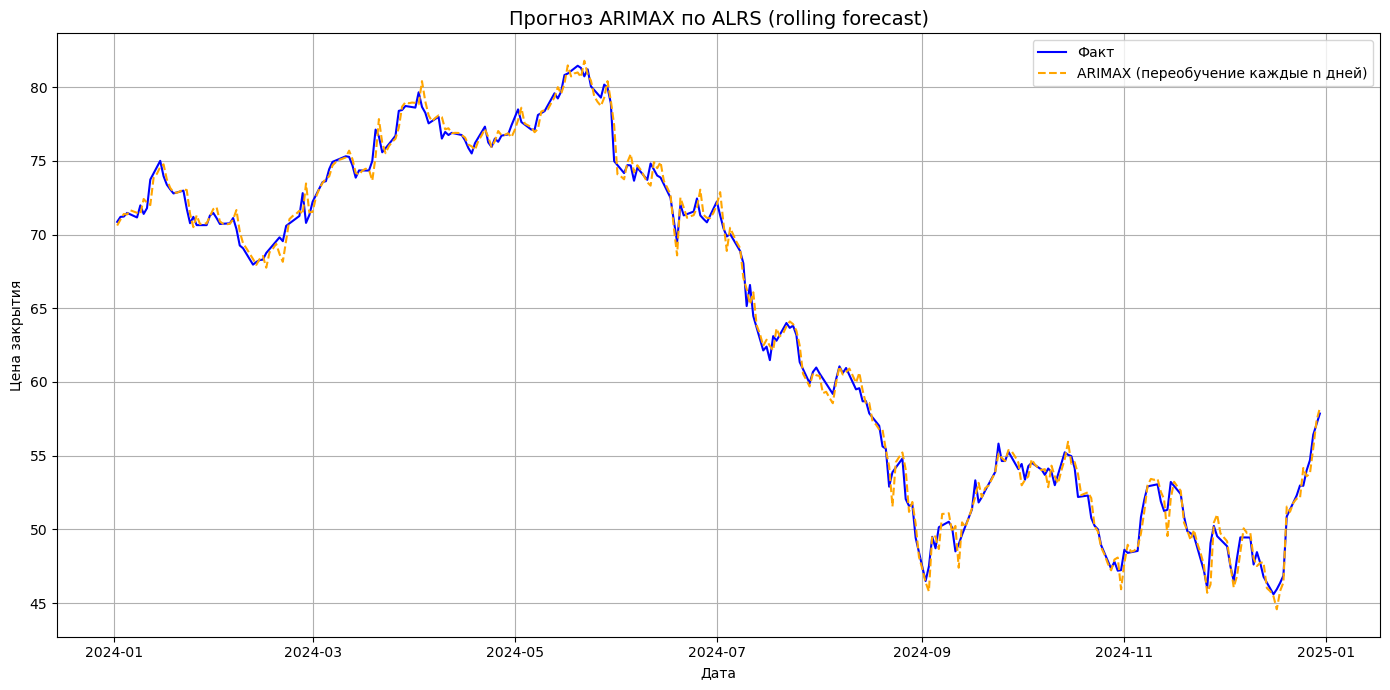

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# === –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö ===
df = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/alrs_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # –£–¥–∞–ª—è–µ–º –∫–æ–Ω—Å—Ç–∞–Ω—Ç—ã

# === –≠–∫–∑–æ–≥–µ–Ω–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ ===
target = "Stock Close"
best_features = ["IMOEX Close", "MOEXOG Close", "CNY Rate"]
best_features = [f for f in best_features if f in df.columns]

# === –û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤ ===
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –ª–∞–≥–æ–≤ —á–µ—Ä–µ–∑ —Ç–µ—Å—Ç –ì—Ä–µ–π–Ω–¥–∂–µ—Ä–∞ ===
optimal_lags = {}
for feature in best_features:
    try:
        result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === –°–æ–∑–¥–∞–Ω–∏–µ –ª–∞–≥–æ–≤ (—Ä–∞–∑ –∏ –Ω–∞–≤—Å–µ–≥–¥–∞) ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === –î–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged[target]
X_train = train_lagged.drop(columns=[target])
y_test = test_lagged[target]
X_test = test_lagged.drop(columns=[target])

# === Rolling –ø—Ä–æ–≥–Ω–æ–∑ —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º ARIMAX ===
forecast_list = []
n_days = min(optimal_lags.values())

print("üîÑ Rolling forecast –Ω–∞—á–∞—Ç...")
start_time = time.time()

for i in tqdm(range(0, len(X_test), n_days), desc="–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ", unit="—à–∞–≥"):
    end_i = min(i + n_days, len(X_test))
    if end_i <= i:
        break

    current_y_train = pd.concat([y_train, y_test.iloc[:i]])
    current_X_train = pd.concat([X_train, X_test.iloc[:i]])
    current_X_forecast = X_test.iloc[i:end_i]

    print(f"üìç –ò—Ç–µ—Ä–∞—Ü–∏—è {i}-{end_i} | –î–∞—Ç–∞: {y_test.index[i].date()}")

    optimal_arima = auto_arima(current_y_train, exogenous=current_X_train, seasonal=False, d=1,
                               trace=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

    model = SARIMAX(current_y_train, exog=current_X_train, order=optimal_arima.order)
    model_fit = model.fit(maxiter=500, disp=False)

    steps_ahead = len(current_X_forecast)
    preds = model_fit.forecast(steps=steps_ahead, exog=current_X_forecast)
    forecast_list.extend(preds)

elapsed_time = time.time() - start_time
print(f"‚úÖ Rolling –ø—Ä–æ–≥–Ω–æ–∑ –∑–∞–≤–µ—Ä—à—ë–Ω –∑–∞ {elapsed_time:.1f} —Å–µ–∫—É–Ω–¥.")

# === –°–±–æ—Ä —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ ===
forecast_df = pd.DataFrame({
    'Date': y_test.index[:len(forecast_list)],
    'Actual Stock Close': y_test.values[:len(forecast_list)],
    'Forecast Stock Close': forecast_list
}).set_index('Date')

# === –ú–µ—Ç—Ä–∏–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ ===
mae = mean_absolute_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close']))
mape = np.mean(np.abs((forecast_df['Actual Stock Close'] - forecast_df['Forecast Stock Close']) / forecast_df['Actual Stock Close'])) * 100

print(f"\nüìä –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø–æ ALRS:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–æ–≥–Ω–æ–∑–∞ ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Stock Close'], label='–§–∞–∫—Ç', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast Stock Close'], label='ARIMAX (–ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ –∫–∞–∂–¥—ã–µ n –¥–Ω–µ–π)', color='orange', linestyle='--')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑ ARIMAX –ø–æ ALRS (rolling forecast)', fontsize=14)
plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞ –∑–∞–∫—Ä—ã—Ç–∏—è')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


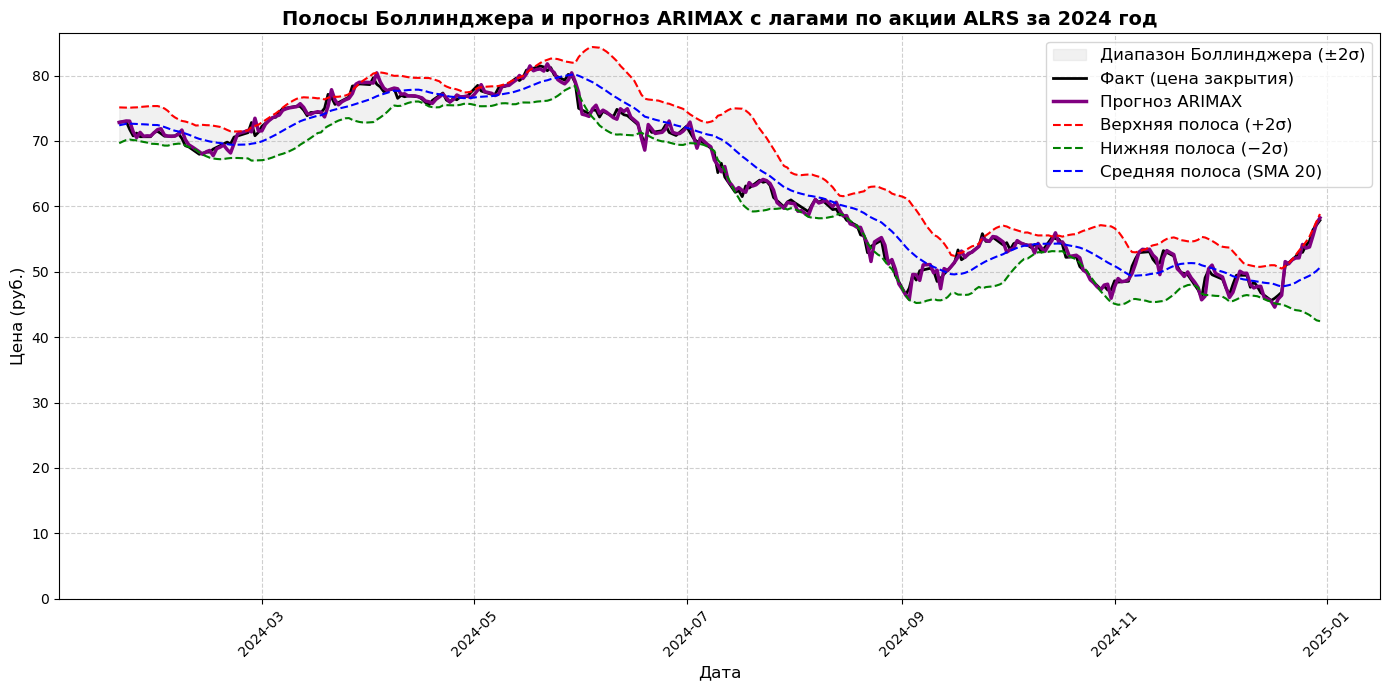

In [14]:
# === –ü–æ–ª–æ—Å—ã –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ –∏ –ø—Ä–æ–≥–Ω–æ–∑ ARIMAX —Å –ª–∞–≥–∞–º–∏ (2024 –≥–æ–¥) ===

# –û—Ç–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö –∑–∞ 2024 –≥–æ–¥
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# –†–∞—Å—á—ë—Ç –ø–æ–ª–æ—Å –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# –ü—Ä–æ–≥–Ω–æ–∑ ARIMAX –∫–∞–∫ Series
forecast_series = forecast_df["Forecast Stock Close"]

# –û–±—â–∏–π –∏–Ω–¥–µ–∫—Å –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
common_index = df_boll.index.intersection(forecast_series.index)

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
forecast_for_boll = forecast_series.loc[common_index]
actual_for_boll = forecast_df["Actual Stock Close"].loc[common_index]
upper = df_boll["bollinger_upper"].loc[common_index]
lower = df_boll["bollinger_lower"].loc[common_index]
mid = df_boll["bollinger_mid"].loc[common_index]

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
plt.figure(figsize=(14, 7))

# –î–∏–∞–ø–∞–∑–æ–Ω –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞
plt.fill_between(common_index, lower, upper, color="lightgray", alpha=0.3, label="–î–∏–∞–ø–∞–∑–æ–Ω –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ (¬±2œÉ)")

# –§–∞–∫—Ç–∏—á–µ—Å–∫–∞—è —Ü–µ–Ω–∞
plt.plot(actual_for_boll.index, actual_for_boll, label="–§–∞–∫—Ç (—Ü–µ–Ω–∞ –∑–∞–∫—Ä—ã—Ç–∏—è)", color="black", linewidth=2)

# –ü—Ä–æ–≥–Ω–æ–∑ ARIMAX
plt.plot(forecast_for_boll.index, forecast_for_boll, label="–ü—Ä–æ–≥–Ω–æ–∑ ARIMAX", color="purple", linewidth=2.5)

# –ü–æ–ª–æ—Å—ã
plt.plot(upper.index, upper, label="–í–µ—Ä—Ö–Ω—è—è –ø–æ–ª–æ—Å–∞ (+2œÉ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="–ù–∏–∂–Ω—è—è –ø–æ–ª–æ—Å–∞ (‚àí2œÉ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="–°—Ä–µ–¥–Ω—è—è –ø–æ–ª–æ—Å–∞ (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# –û—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ
plt.title("–ü–æ–ª–æ—Å—ã –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ –∏ –ø—Ä–æ–≥–Ω–æ–∑ ARIMAX —Å –ª–∞–≥–∞–º–∏ –ø–æ –∞–∫—Ü–∏–∏ ALRS –∑–∞ 2024 –≥–æ–¥", fontsize=14, fontweight="bold")
plt.xlabel("–î–∞—Ç–∞", fontsize=12)
plt.ylabel("–¶–µ–Ω–∞ (—Ä—É–±.)", fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
